In [1]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install gensim==3.8.3 --quiet
!pip install -U tensorflow_text==2.8.2 --quiet
!pip install tensorflow-datasets --quiet
!pip install pydot --quiet
!pip install tensorflow==2.8.2 --quiet

     |████████████████████████████████| 451 kB 4.6 MB/s 
     |████████████████████████████████| 115 kB 74.7 MB/s 
     |████████████████████████████████| 182 kB 54.8 MB/s 
     |████████████████████████████████| 212 kB 62.6 MB/s 
     |████████████████████████████████| 127 kB 69.1 MB/s 
     |████████████████████████████████| 5.5 MB 5.0 MB/s 
     |████████████████████████████████| 7.6 MB 31.4 MB/s 
     |████████████████████████████████| 24.2 MB 1.2 MB/s 
     |████████████████████████████████| 4.9 MB 4.5 MB/s 
     |████████████████████████████████| 497.9 MB 4.3 kB/s 
     |████████████████████████████████| 1.4 MB 58.4 MB/s 
     |████████████████████████████████| 462 kB 75.7 MB/s 
     |████████████████████████████████| 5.8 MB 58.2 MB/s 
     |████████████████████████████████| 437.8 MB 40 kB/s 


In [2]:
import os
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import pandas as pd
import transformers
import gensim
from datasets import load_dataset

from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from pprint import pprint 
from datasets import load_dataset
from nltk.corpus import reuters
from nltk.data import find
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from transformers import BertTokenizer, TFBertModel

In [3]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
df = pd.read_csv(url, index_col=0)
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Field Description from  Davidson et.al github

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [4]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


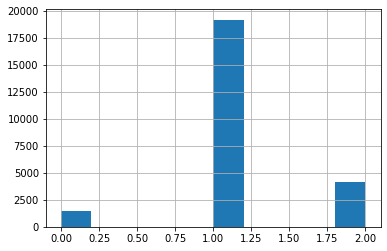

In [5]:
df['class'].hist()

In [6]:
df['tweet'].head()

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object

Light Data Cleaning

In [7]:
df['tweet'][0].split(": ")[1:]

["As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."]

In [8]:
# Remove the initial exclamation points and the RT twitter handles
df['tweet'] = df['tweet'].apply(lambda x: ": ".join(x.split(": ")[1:]) if len(x.split(": ")) > 1 else x)
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                       @viva_based she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    @20_Pearls @corey_emanuel right! His TL is tra...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [9]:
# remove the unicode symbols 
import re
df['tweet'] = df['tweet'].apply(lambda x: re.sub("&#\d+","",x))

# remove other @handles 
df['tweet'] = df['tweet'].apply(lambda x: re.sub("@[^ ]+ ","",x))
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                                   she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    right! His TL is trash ;. Now, mine? Bible scr...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [10]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about cleani...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,You ever fuck a bitch and she start to cry? Yo...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or it...
...,...,...,...,...,...,...
25291,3,0,2,1,1,"right! His TL is trash ;. Now, mine? Bible scr..."
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


Very large skew towards offensive langauge in the dataset

In [11]:
training_tweets, testing_tweets = train_test_split(df, test_size=0.2, random_state=25, stratify = df['class'])
valid_tweets, testing_tweets = train_test_split(testing_tweets, test_size = 0.5, random_state=25, stratify = testing_tweets['class'])

In [12]:
print(f"No. of training examples: {training_tweets.shape[0]}")
print(f"No. of validation examples: {valid_tweets.shape[0]}")
print(f"No. of testing examples: {testing_tweets.shape[0]}")

No. of training examples: 19826
No. of validation examples: 2478
No. of testing examples: 2479


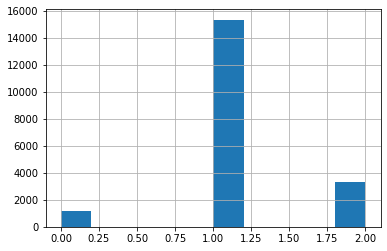

In [13]:
training_tweets['class'].hist()

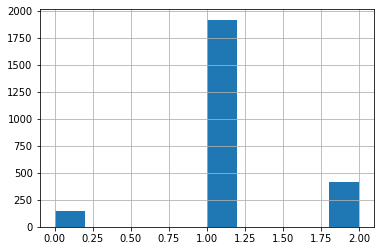

In [14]:
valid_tweets['class'].hist()

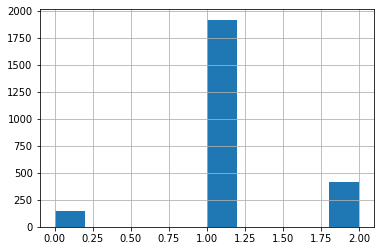

In [15]:
testing_tweets['class'].hist()

In [16]:
# get average length of tweets in the various sets
print("Average word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print("Min max word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).min())
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).max())

print("Average character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x)).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x)).mean())

print("Min max character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).min())
print(training_tweets['tweet'].apply(lambda x: len(x)).max())

Average word length
12.859427015030768
12.792171105730429
12.939491730536506
Min max word length
1
36
Average character length
68.69106224150106
68.10290556900726
68.71803146430013
Min max character length
1
148


## BERT Tweet Model

In [17]:
model_checkpoint = 'bert-base-uncased'
#model_checkpoint = 'vinai/bertweet-large'

In [28]:
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
max_length = 75

In [30]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(list(training_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [31]:
train_encodings.input_ids.shape

print('train_encodings shape = ', train_encodings.input_ids.shape)
print('valid_encodings shape = ', valid_encodings.input_ids.shape)
print('test_encodings shape = ', test_encodings.input_ids.shape)

train_encodings shape =  (19826, 75)
valid_encodings shape =  (2478, 75)
test_encodings shape =  (2479, 75)


In [32]:
#print('tlabels_encodings shape = ', tlabels_encodings.input_ids.shape)
#print('vlabels_encodings shape = ', vlabels_encodings.input_ids.shape)

In [33]:
train_encodings

{'input_ids': <tf.Tensor: shape=(19826, 75), dtype=int32, numpy=
array([[  101,  8840,  2140, ...,     0,     0,     0],
       [  101,  2123,  1005, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0],
       ...,
       [  101,  8112,  7110, ...,     0,     0,     0],
       [  101,  9152, 23033, ...,     0,     0,     0],
       [  101,  1045,  5223, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(19826, 75), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(19826, 75), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [34]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                hidden_size = 76, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  #bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bert_model(bert_inputs)
  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [35]:
#pooled_bert_model = create_bert_multiclass_model(checkpoint = model_checkpoint, hidden_size = 100, dropout=0.1, learning_rate=learning_rate)
pooled_bert_model = create_bert_multiclass_model()
pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1) 
score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1]) 

78/78 [==============================] - 14s 176ms/step - loss: 0.2724 - accuracy: 0.9104
Test loss: 0.27242961525917053
Test accuracy: 0.9104477763175964


In [36]:
pooled_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 75)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 75)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 75)]        0           []                               
 er)                                                                                              
                                                                                              